In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive/LeafDeseaseDetection/

/content/drive/MyDrive/LeafDeseaseDetection


In [ ]:
!unzip skin-cancer-mnist-ham10000.zip

In [3]:
import os
import numpy as np
from PIL import Image
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from sklearn.metrics import classification_report


In [4]:
classes = {
  'nv': 0, # Melanocytic nevi'
  'mel': 1, # Melanoma'
  'bkl': 2, # Benign keratosis-like lesions'
  'bcc': 3, # Basal cell carcinoma'
  'akiec': 4, # Actinic keratoses'
  'vasc': 5, # Vascular lesions'
  'df': 6, # Dermatofibroma
}

image_paths = {}

for folder in ['HAM10000_images_part_1', 'HAM10000_images_part_2']:
  for image in os.listdir(folder):
    image_paths[os.path.splitext(image)[0]] = os.path.join(folder, image)


In [5]:
data = pd.read_csv('HAM10000_metadata.csv')
data = data.dropna()
data.isnull().any().sum()
data['class'] = data['dx'].map(classes.get)
data = data.sort_values('class')
data = data.reset_index()


In [37]:
import shutil, os
os.mkdir('ham10000')
os.mkdir('ham10000/train')
os.mkdir("ham10000/test")
for c in classes:
  os.mkdir(os.path.join('ham10000/train', c))
  os.mkdir(os.path.join('ham10000/test', c))


for c in classes:
  temp = data[data['dx'] == c]
  train, test = train_test_split(temp, test_size=0.2)

  for index, row in train.iterrows():
    shutil.copy(image_paths[row['image_id']], os.path.join('ham10000/train', row['dx'], image_paths[row['image_id']].split('/')[-1]))
  for index, row in test.iterrows():
    shutil.copy(image_paths[row['image_id']], os.path.join('ham10000/test', row['dx'], image_paths[row['image_id']].split('/')[-1]))

In [6]:
count = 0

for c in classes:
  count += len(os.listdir(f'ham10000/train/{c}'))
  count += len(os.listdir(f'ham10000/test/{c}'))

print(count, data.shape[0])

9958 9958


In [45]:
!rm -r 'ham10000/train/.ipynb_checkpoints'
!rm -r 'ham10000/test/.ipynb_checkpoints'

rm: cannot remove 'ham10000/train/.ipynb_checkpoints': No such file or directory


In [19]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'ham10000/train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(28, 28),
  shuffle=True,
  batch_size=16)

Found 7964 files belonging to 7 classes.
Using 6372 files for training.


In [20]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  'ham10000/test',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(28, 28),
  shuffle=True,
  batch_size=16)

Found 1994 files belonging to 7 classes.
Using 398 files for validation.


In [21]:
class_names = train_ds.class_names
print(class_names)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


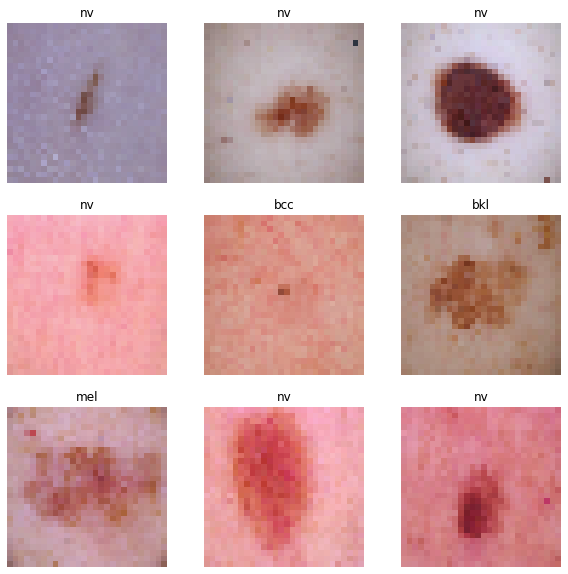

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [23]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

model.add(tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), padding = 'same'))

model.add(tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), padding = 'same'))
model.add(tf.keras.layers.Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), padding = 'same'))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation = 'relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(7, activation='softmax'))

In [24]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = optimizer,
    metrics = ['accuracy']
)

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 4, 4, 64)        

In [25]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1, 
    mode='auto'
)
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3, 
    verbose=1,
    mode='auto'
)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

In [26]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_test_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

model.fit(
    normalized_train_ds,
    validation_data=normalized_test_ds,
    batch_size = 64,
    epochs = 200,
    callbacks = [early_stopping_callback, reduce_lr_callback, tensorboard_callback]
)

Epoch 1/200
399/399 [==============================] - 43s 105ms/step - loss: 1.0287 - accuracy: 0.6714 - val_loss: 1.0104 - val_accuracy: 0.6357 - lr: 0.0010
Epoch 2/200
399/399 [==============================] - 40s 97ms/step - loss: 0.9131 - accuracy: 0.6855 - val_loss: 0.9220 - val_accuracy: 0.6482 - lr: 0.0010
Epoch 3/200
399/399 [==============================] - 32s 79ms/step - loss: 0.8611 - accuracy: 0.6944 - val_loss: 0.8997 - val_accuracy: 0.6558 - lr: 0.0010
Epoch 4/200
399/399 [==============================] - 34s 83ms/step - loss: 0.8149 - accuracy: 0.7009 - val_loss: 0.8355 - val_accuracy: 0.6608 - lr: 0.0010
Epoch 5/200
399/399 [==============================] - 43s 106ms/step - loss: 0.7650 - accuracy: 0.7148 - val_loss: 0.7932 - val_accuracy: 0.6759 - lr: 0.0010
Epoch 6/200
399/399 [==============================] - 40s 98ms/step - loss: 0.7366 - accuracy: 0.7279 - val_loss: 0.7731 - val_accuracy: 0.6985 - lr: 0.0010
Epoch 7/200
399/399 [=============================

In [27]:
model.save("skin_classifier_model.h5")

In [33]:
# model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
# print("Test Accuracy: {:.3f}%".format(model_acc * 100))
y_pred = model.predict(normalized_test_ds)
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
# clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
# print(clr)

In [45]:
y_true = np.array([])
y_pred_ = np.array([])

for x, y in normalized_test_ds:
  y_pred = model.predict(x)
  y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
  y_true = np.concatenate((y_true, y.numpy()))
  y_pred_ = np.concatenate((y_pred_, y_pred))

In [47]:
clr = classification_report(y_true, y_pred_, target_names=classes.keys())
print(clr)

              precision    recall  f1-score   support

          nv       0.43      0.20      0.27        15
         mel       0.42      0.55      0.48        20
         bkl       0.50      0.50      0.50        36
         bcc       0.00      0.00      0.00         4
       akiec       0.65      0.42      0.51        62
        vasc       0.85      0.94      0.89       253
          df       0.78      0.88      0.82         8

    accuracy                           0.76       398
   macro avg       0.52      0.50      0.50       398
weighted avg       0.74      0.76      0.74       398



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
